# Recommender ChatBot: Update Users and Items embeddings using DeepFM model

Generate users/items embeddings using DeepFM collaborative filtering model Then store embeddings into a chromadb database.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
BASE_PATH    = '../..'
LIB_PATH     = f'{BASE_PATH}/lib'
API_PATH     = f'{BASE_PATH}/chat-bot-api'

In [3]:
import sys
sys.path.append(LIB_PATH)
sys.path.append(API_PATH)


import torch
import pytorch_common
import pytorch_common.util as pu
import util as ut
import os

import rest
import pandas as pd

import service as srv
import os
import pytorch_common.util as pu
import rest
import pandas as pd
import torch
import data.dataset as ds
import data as dt
import logging
import util as ut
from models import EntityEmb
from bunch import Bunch 
import logging
import sys

2024-02-11 12:59:41.637143: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-11 12:59:42.035363: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-02-11 12:59:42.405226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-11 12:59:42.415950: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GP

<Figure size 640x480 with 0 Axes>

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
import pytorch_common
pytorch_common.__version__

'0.3.8'

In [6]:
torch.__version__

'2.1.2+cu118'

In [7]:
pu.set_device_name('gpu')

pu.get_device(), torch.cuda.is_available()

(device(type='cuda', index=0), True)

In [8]:
ut.set_seed(42)

In [9]:
os.environ['TMP_PATH']         = f'{BASE_PATH}/tmp'
os.environ['DATASET_PATH']     = f'{BASE_PATH}/datasets'
os.environ['WEIGHTS_PATH']     = f'{BASE_PATH}/weights'
os.environ['METRICS_PATH']     = f'{BASE_PATH}/metrics'
os.environ['MONGODB_URL']      = 'mongodb://0.0.0.0:27017'
os.environ['MONGODB_DATABASE'] = 'chatbot'
os.environ['CHROMA_HOST']      = '0.0.0.0'
os.environ['CHROMA_PORT']      = '9090'


from app_context import AppContext

## Run Job

In [10]:
ctx = AppContext()

# model, rating_mean_df, rating_std, interactions_df = AppContext().cf_emb_update_job()

2024-02-11 12:59:44,131 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-02-11 12:59:44,677 - INFO - Use pytorch device: cuda
2024-02-11 12:59:44,679 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-02-11 12:59:44,699 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [11]:
api_client      = rest.RecChatBotV1ApiClient()
interactions_df = pd.DataFrame(api_client.interactions())

logging.info(interactions_df.shape)


data_splitter = ds.TrainTestSplitter(
  n_min_interactions = 20,
  test_size          = 0.1,
  cols               = Bunch(
    order_col   = 'timestamp',
    user_id     = 'user_id',
    item_id     = 'item_id',
    rating      = 'rating',
    rating_mean = 'rating_mean',
    rating_norm = 'rating_norm' 
  )
)

train_set, test_set, rating_mean_df, rating_std = data_splitter(interactions_df)


# Generate sequences....
user_sequencer = dt.Sequencer('user_id', 'user_seq')
item_sequencer = dt.Sequencer('item_id', 'item_seq')

train_set = user_sequencer.perform(train_set)
train_set = item_sequencer.perform(train_set)

test_set = user_sequencer.perform(test_set)
test_set = item_sequencer.perform(test_set)

2024-02-11 12:59:49,990 - INFO - (190025, 4)
2024-02-11 12:59:52,145 - INFO - Train: 71.28 % - Test: 8.13 %


In [12]:
model_loader = srv.DeepFMLoader(
    weights_path          = os.environ['WEIGHTS_PATH'],
    metrics_path          = os.environ['METRICS_PATH'],
    tmp_path              = os.environ['TMP_PATH'],
    user_seq_col          = 'user_seq',
    item_seq_col          = 'item_seq',
    update_period_in_min  = 1,
    params              = Bunch({
        'model': Bunch({
            'units_per_layer'   : [20, 1],
            'dropout'           : 0.2,
            'embedding_size'    : 50,
        }),
        'train': Bunch({
            'lr'         : 0.001,
            'lr_factor'  : 0.1,
            'lr_patience': 4,
            'epochs'     : 7,
            'n_workers'  : 24,
            'batch_size' : 1024,
            'eval_percent': 0.15
        }),
        'metrics': Bunch({
            'n_samples'  : 250,
            'batch_size' : 2000
        })
    })
)

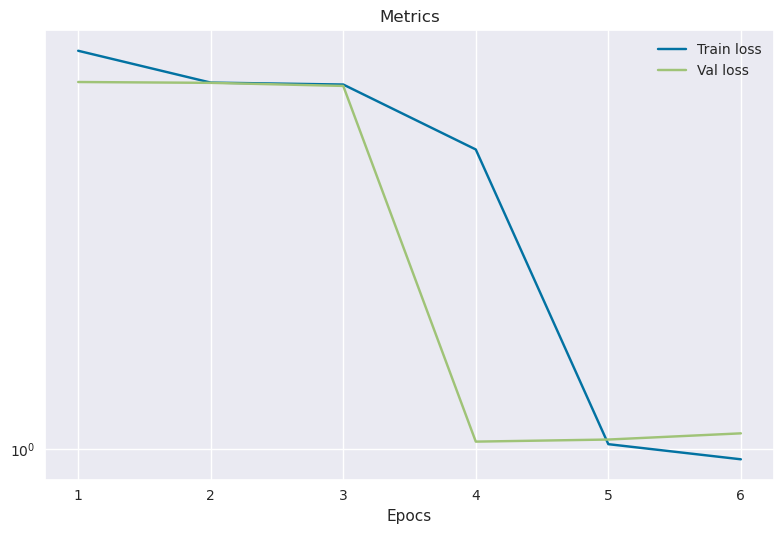

2024-02-11 13:00:45,365 - INFO - {'time': '0:00:06.97', 'epoch': 7, 'train_loss': 0.8948238039375248, 'val_loss': 1.0949182510375977, 'lr': 0.001}


Processing:   0%|          | 0/250 [00:00<?, ?it/s]

Ordered by mAP@5(4,5):


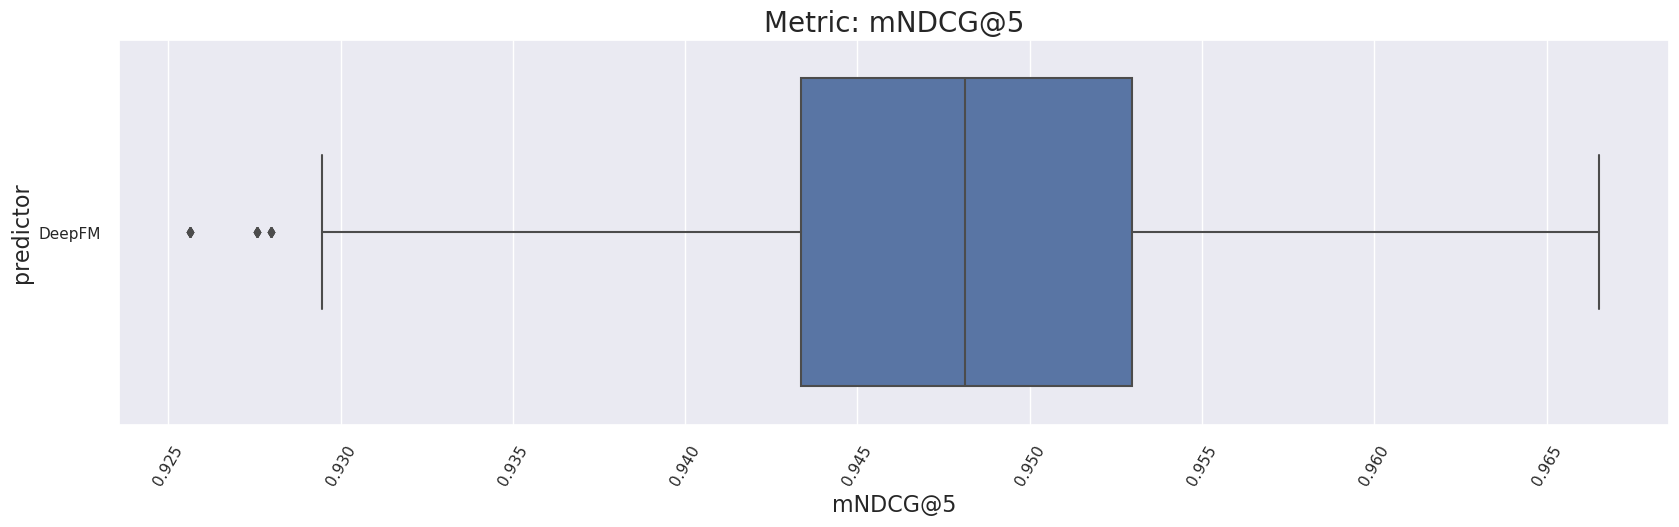

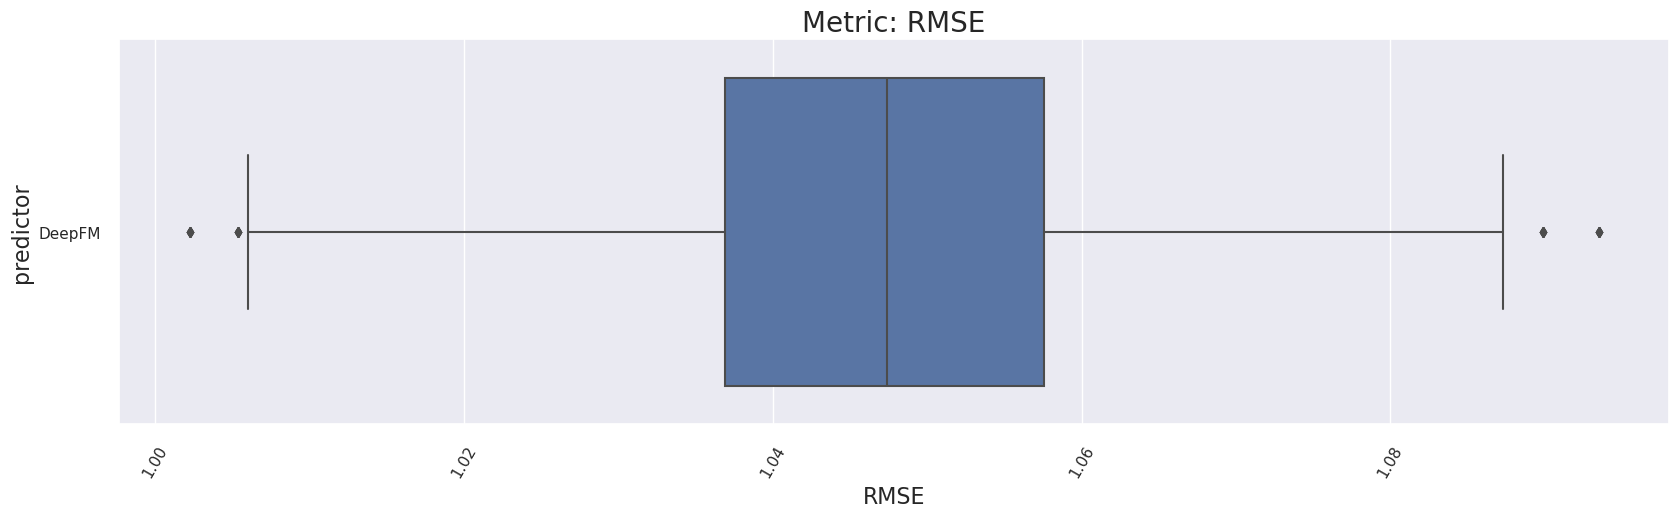

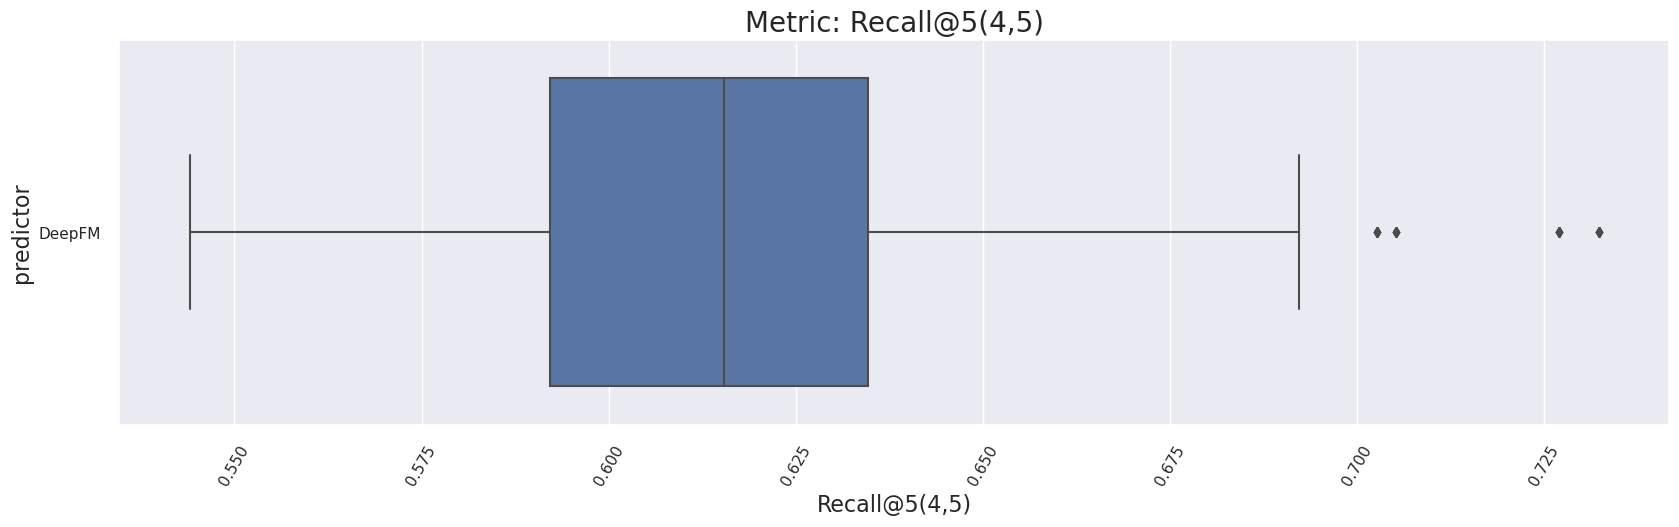

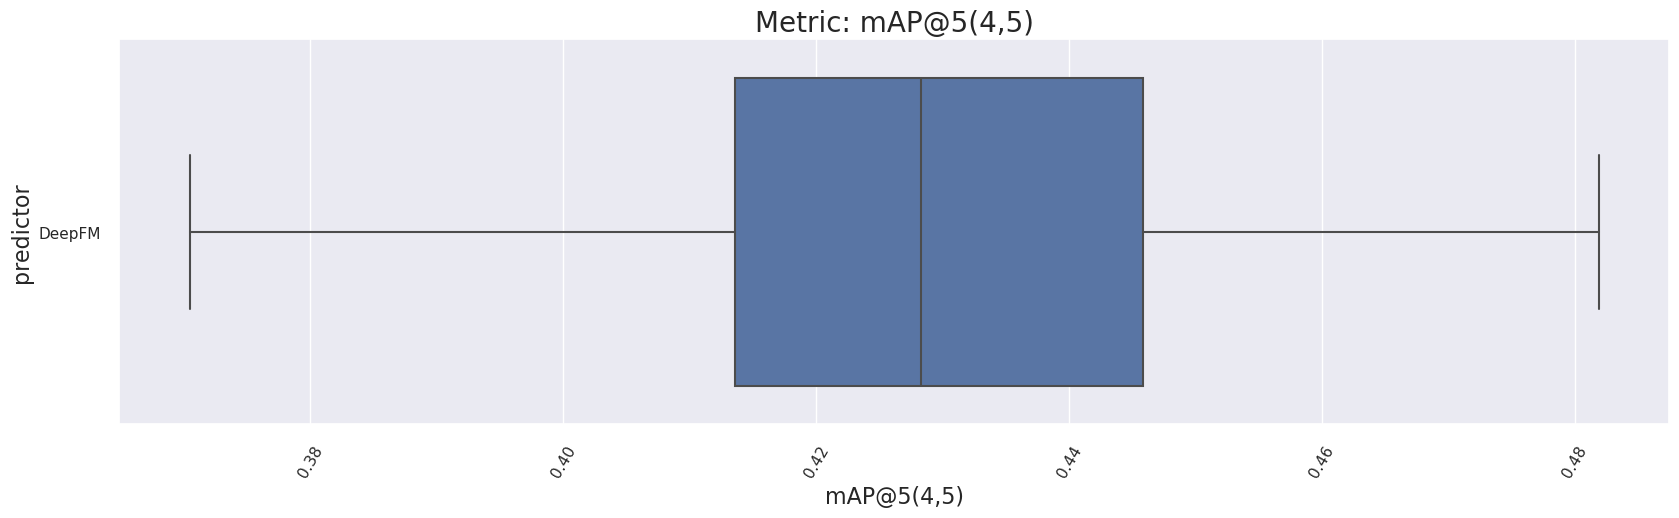

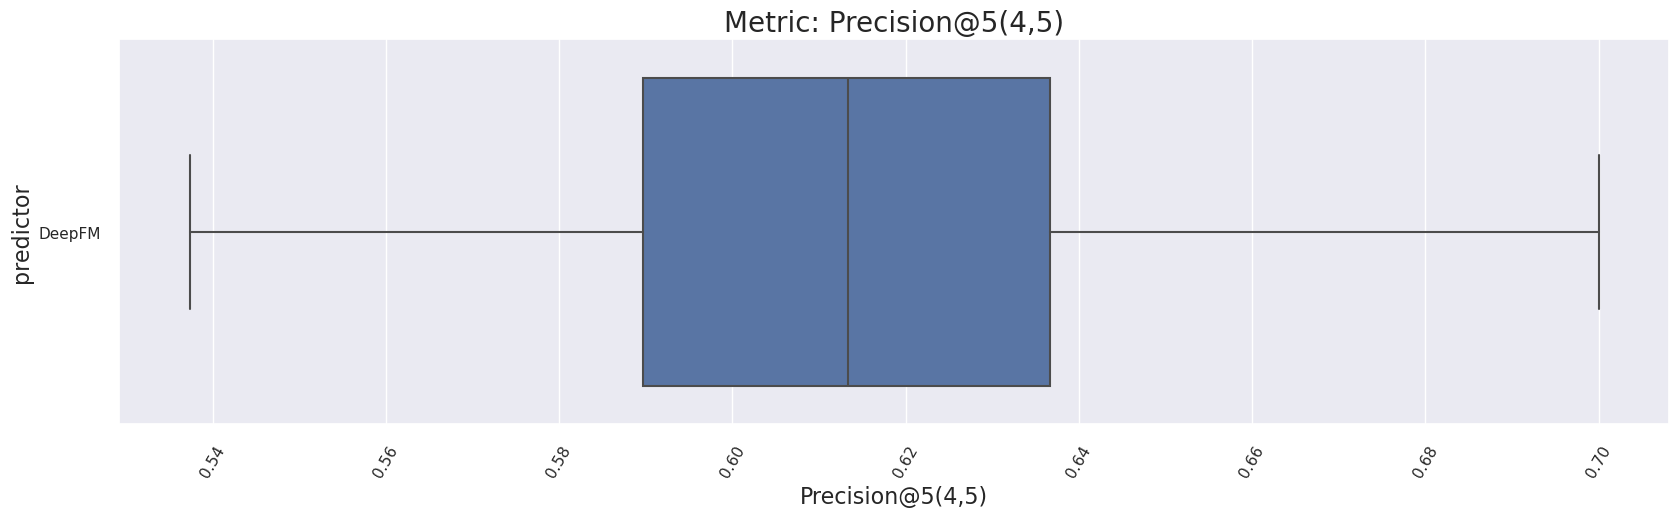

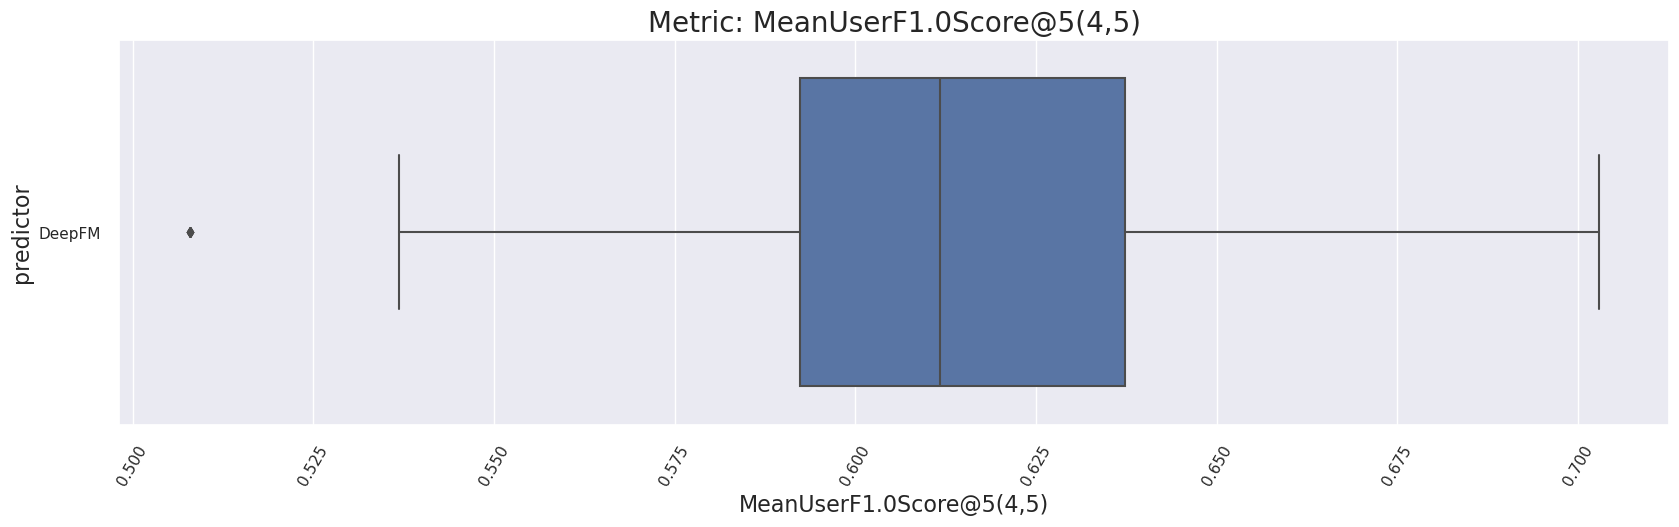

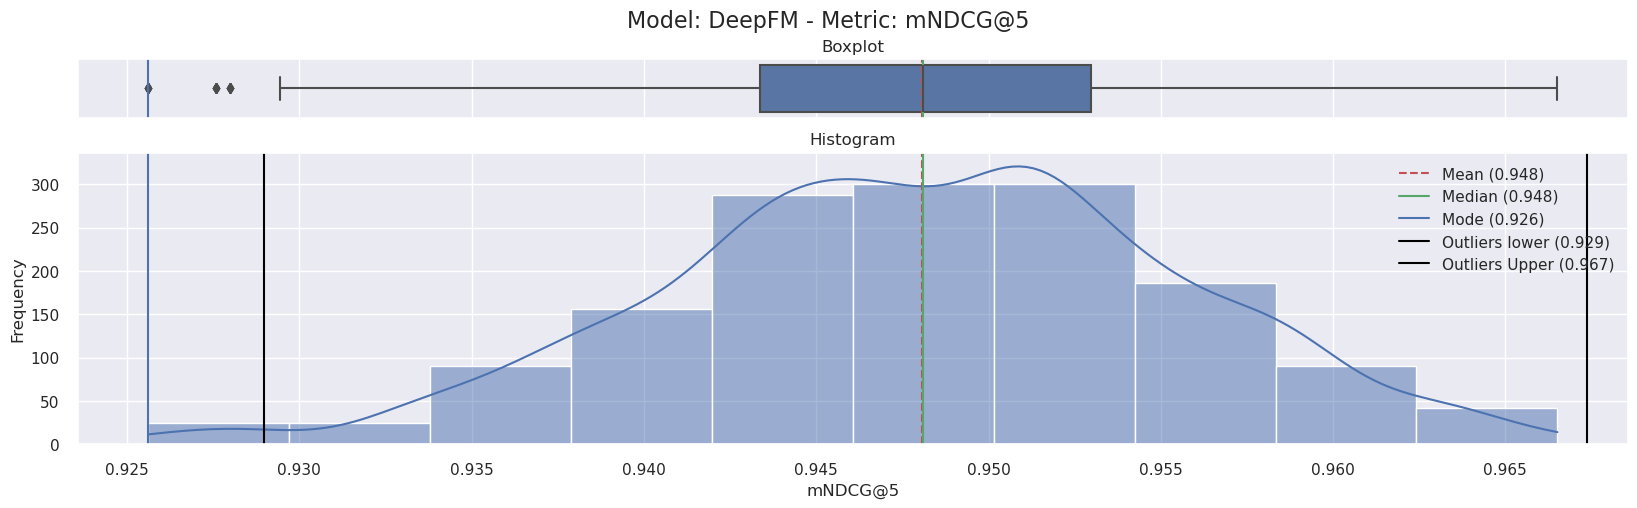

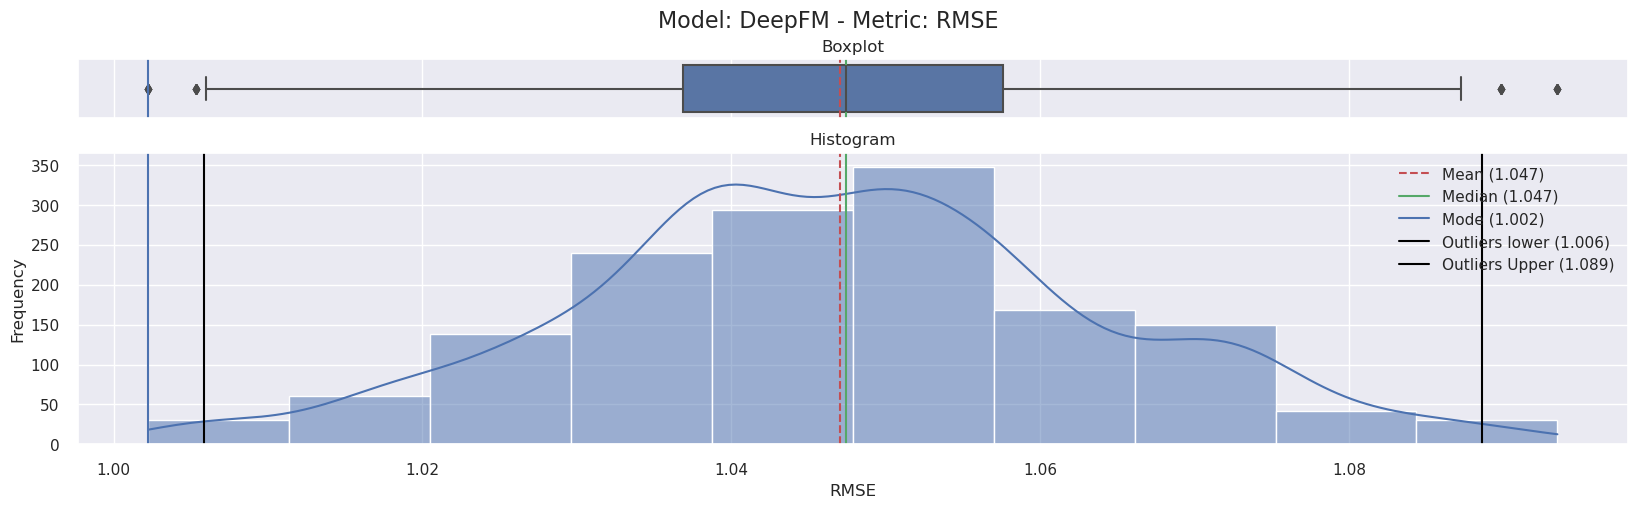

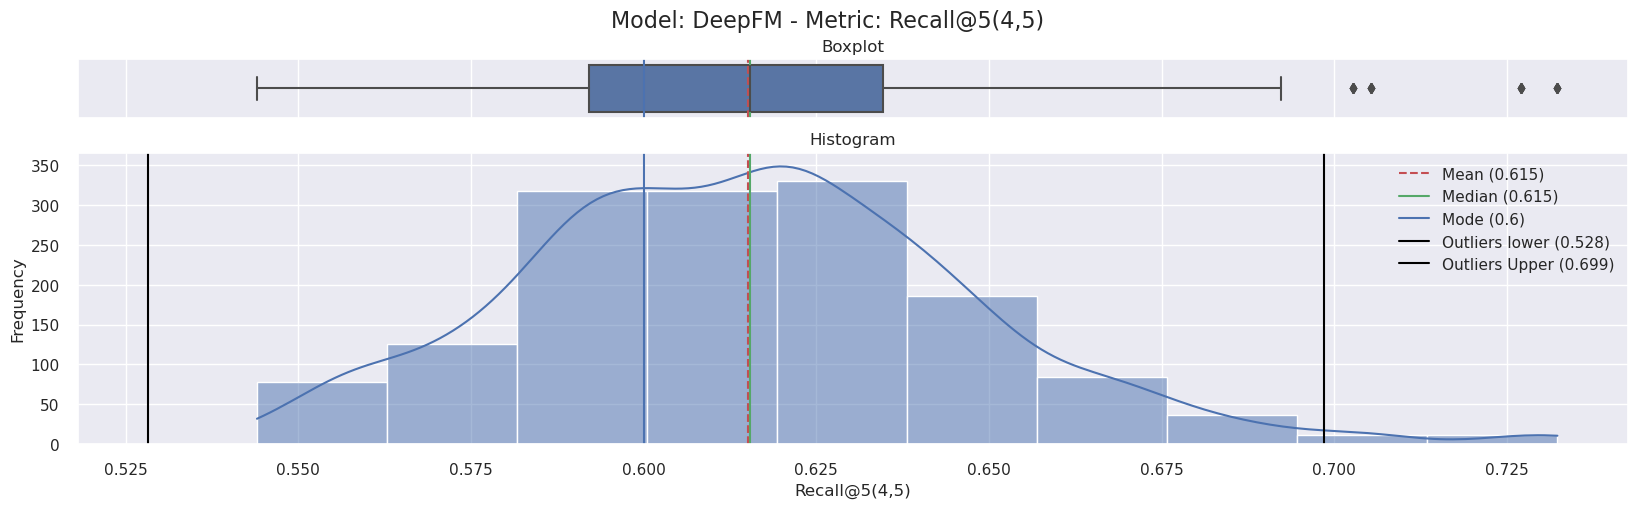

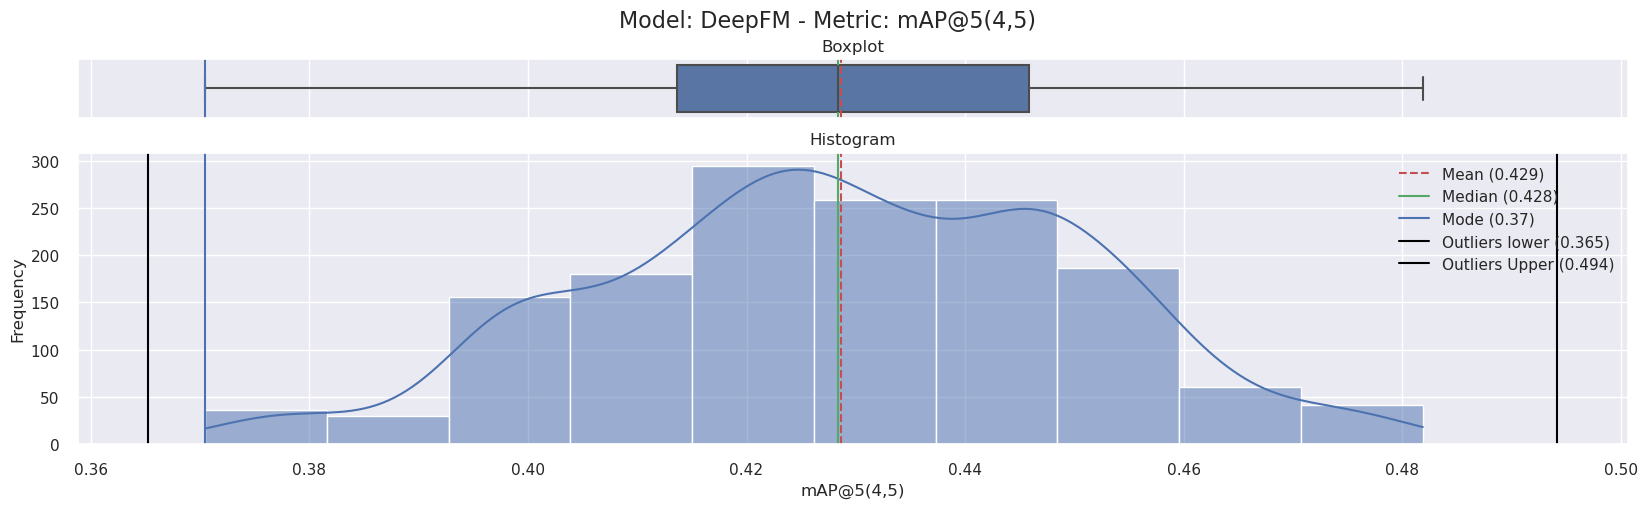

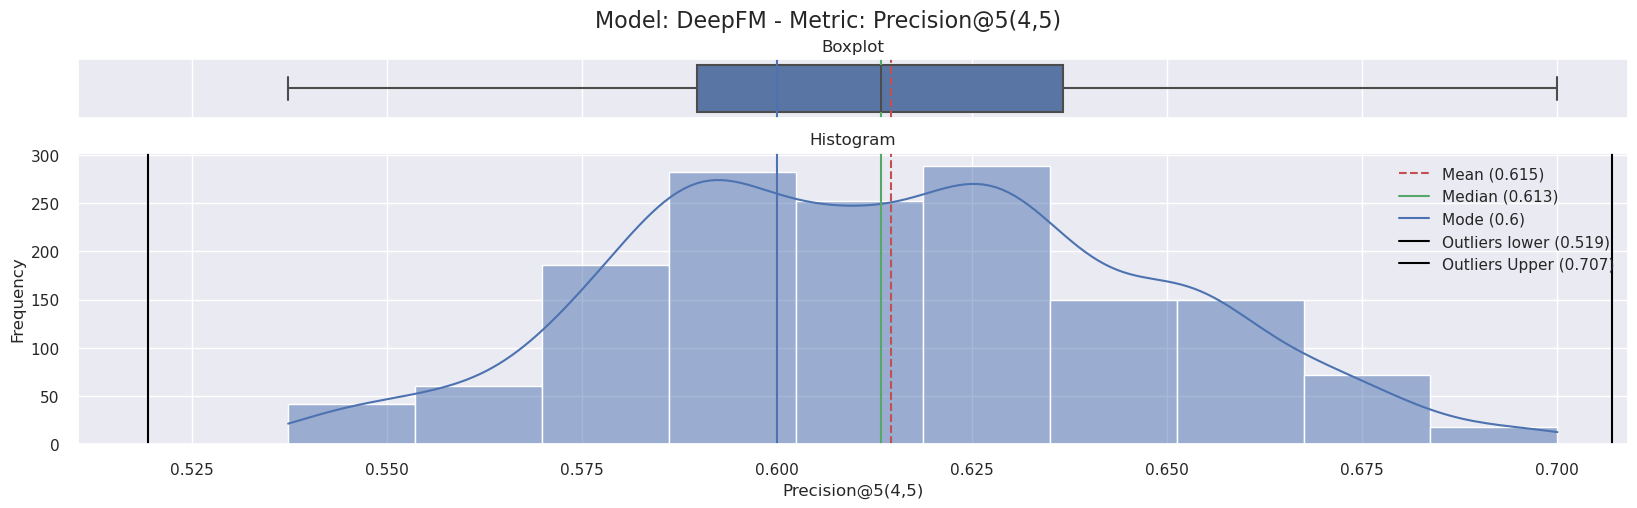

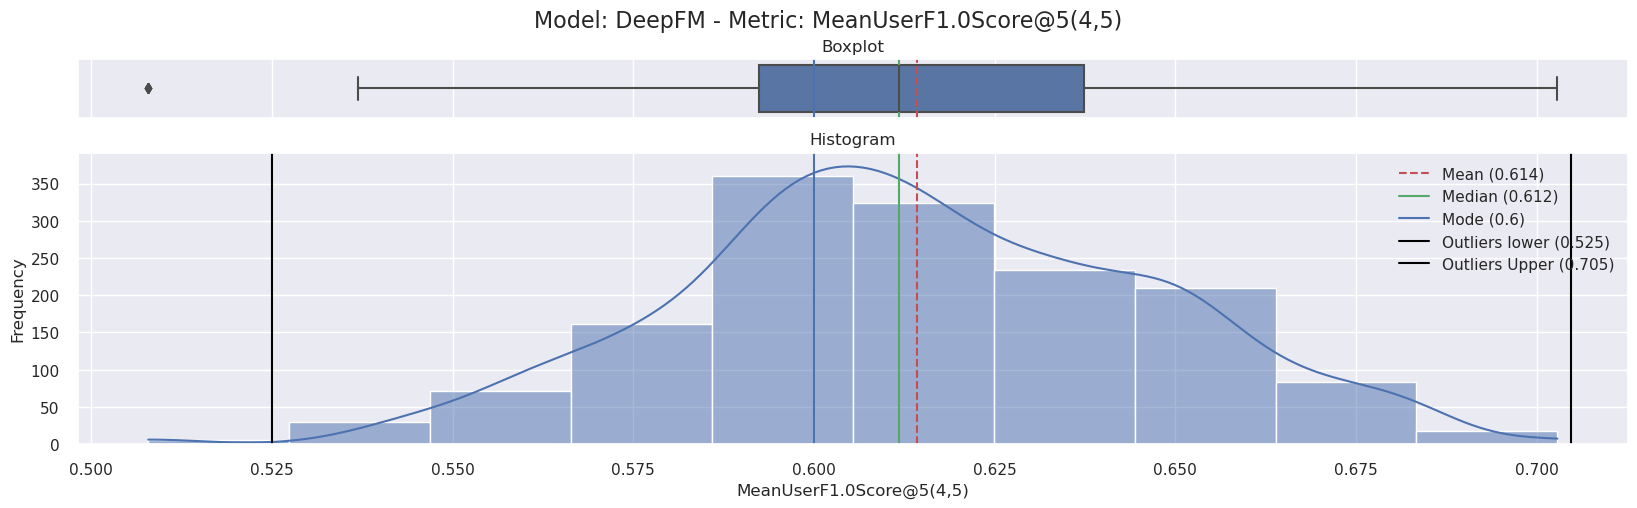

In [13]:
model, params = model_loader.load(train_set, test_set)

In [31]:
[user_embeddings, item_embeddings] = model.embedding.feature_embeddings

def to_entity_embs(df, seq_col, id_col, embeddings):
    seq_to_id = ut.to_dict(df, seq_col, id_col)
    return [
        EntityEmb(
            id  = str(id),
            emb = embeddings[seq].tolist()
        )
          for seq, id in seq_to_id.items()
    ]

user_embs = train_set.pipe(to_entity_embs, 'user_seq', 'user_id', user_embeddings)
ctx.users_cf_emb_repository.upsert_many(user_embs)

item_embs = train_set.pipe(to_entity_embs, 'item_seq', 'item_id', item_embeddings)
ctx.items_cf_emb_repository.upsert_many(item_embs)

2024-02-11 13:18:14,866 - INFO - Get feature 0 embeddings [1736, 50]. Detail: Embeddings from 0 to 1735 from weights [16222, 50]
2024-02-11 13:18:14,867 - INFO - Get feature 1 embeddings [14486, 50]. Detail: Embeddings from 1736 to 16221 from weights [16222, 50]


Insert Embeddings:   0%|          | 0/1736 [00:00<?, ?it/s]

Insert Embeddings:   0%|          | 0/14486 [00:00<?, ?it/s]

In [30]:
train_set[train_set['user_id'].str.contains('@')].head()

,user_id,item_id,rating,timestamp,rating_mean,rating_norm,user_seq,item_seq
103139,adrianmarino@gmail.com,170957,4.0,2024-02-10 14:37:33,4.454545,-0.436834,1735,4323
40474,adrianmarino@gmail.com,8783,5.0,2024-02-10 14:37:33,4.454545,0.524201,1735,690
62899,adrianmarino@gmail.com,2153,4.0,2024-02-10 14:37:33,4.454545,-0.436834,1735,1439
57274,adrianmarino@gmail.com,122892,4.0,2024-02-10 14:37:33,4.454545,-0.436834,1735,1187
4563,adrianmarino@gmail.com,2762,5.0,2024-02-10 14:37:33,4.454545,0.524201,1735,67


## Simple item embeddings evaluation

In [20]:
def to_df(items, distances):
    items_df = pd.DataFrame.from_records([i.dict(exclude_none=True) for i in items])
    items_df['distance'] = distances
    return items_df.loc[:, ~items_df.columns.isin(['embedding'])]

In [24]:
ctx = AppContext()

items, distances = await ctx.item_service.find_by_content('Terminator')
items_df = to_df(items, distances)

2024-02-11 13:07:38,410 - INFO - Load pretrained SentenceTransformer: all-mpnet-base-v2
2024-02-11 13:07:38,907 - INFO - Use pytorch device: cuda
2024-02-11 13:07:38,908 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2024-02-11 13:07:38,908 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [25]:
items_df[['id', 'title', 'release', 'genres', 'rating']]

,id,title,release,genres,rating
0,120799,Terminator Genisys,2015,"[action, adventure, sci-fi, thriller]",2.692308
1,1240,"Terminator, The",1984,"[action, sci-fi, thriller]",3.862069
2,589,Terminator 2: Judgment Day,1991,"[action, sci-fi]",4.052133
3,6537,Terminator 3: Rise of the Machines,2003,"[action, adventure, sci-fi]",3.069444
4,68791,Terminator Salvation,2009,"[action, adventure, sci-fi, thriller]",2.875000


In [26]:
toy_story = ctx.items_cf_emb_repository.find_by_id(items_df.iloc[1,:].id)
toy_story_2 = ctx.items_cf_emb_repository.find_by_id(items_df.iloc[2,:].id)

from scipy.spatial import distance
distance.cosine(toy_story.emb, toy_story_2.emb)

0.44162173529593374

In [27]:
similars = ctx.items_cf_emb_repository.find_similars_by_id(toy_story_2.id, limit=3)

similars_df = pd.DataFrame(data={
    'id'       : [str(i) for i in similars.ids],
    'distance' : similars.distances
})
similars_df

,id,distance
0,589,0.000000
1,60566,0.012526
2,3066,0.013725


In [28]:
similar_items = await ctx.item_service.find_by_ids([str(s) for s in similars.ids])

In [29]:
df = pd.DataFrame.from_records([i.dict(exclude_none=True) for i in similar_items])

df.merge(similars_df, on=['id'])[['distance', 'rating', 'id', 'title', 'genres', 'release']].sort_values(by=['distance'])

,distance,rating,id,title,genres,release
1,0.000000,4.052133,589,Terminator 2: Judgment Day,"[action, sci-fi]",1991
2,0.012526,4.250000,60566,Just Another Love Story,"[crime, drama, thriller]",2007
0,0.013725,3.800000,3066,Tora! Tora! Tora!,"[action, drama, war]",1970
